In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

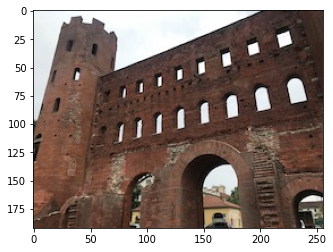

In [2]:
img = cv2.imread("../thorino.jpg")
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

In [19]:
class CannyEdgeDetector:
    def BGR2GRAY(self, img):
        b = img[:, :, 0].copy()
        g = img[:, :, 1].copy()
        r = img[:, :, 2].copy()
        output_image = (0.2126*r + 0.7152*g + 0.0722*b).astype("uint8")
        return output_image
    
    def gaussian_filter(self, img, ksize=5, sigma=1.4):
        K = np.zeros((ksize, ksize))
        for i in range(ksize):
            for j in range(ksize):
                x = i - (ksize - 1) // 2
                y = j - (ksize - 1) // 2
                a = -(x*x+y*y)/(2*(sigma**2))
                K[i, j] = 1/(2*np.pi*(sigma**2)) * np.exp(a)
        K /= np.sum(K)

        pad = ksize // 2
        H, W = img.shape
        input_image = np.zeros((H+2*pad, W+2*pad))
        output_image = input_image.copy()
        input_image[pad:H+pad, pad:W+pad] = img.copy().astype(np.float)
        for i in range(H):
            for j in range(W):
                output_image[pad+i, pad+j] = np.sum(K * input_image[i:i+ksize, j:j+ksize])
                output_image[pad+i, pad+j] = np.clip(output_image[pad+i, pad+j], 0, 255).astype("uint8")
        output_image = output_image[pad:pad+H, pad:pad+W]
        return output_image
    
    def sobel_filter_v(self, img):
        ksize = 3
        pad = ksize // 2
        K = [ [1, 2, 1], [0, 0, 0], [-1, -2, -1] ]

        H, W = img.shape
        input_image = np.zeros((H+2*pad, W+2*pad))
        input_image[pad:pad+H, pad:pad+W] = img.copy()
        output_image = input_image.copy()
        for i in range(H):
            for j in range(W):
                output_image[pad+i, pad+j] = np.sum(K * input_image[i:i+ksize, j:j+ksize])
        output_image = np.clip(output_image[pad:pad+H, pad:pad+W], 0, 255).astype("uint8")
        return output_image
    
    def sobel_filter_h(self, img):
        ksize = 3
        pad = ksize // 2
        K = [ [1, 0, -1], [2, 0, -2], [1, 0, -1] ]

        H, W = img.shape
        input_image = np.zeros((H+2*pad, W+2*pad))
        input_image[pad:pad+H, pad:pad+W] = img.copy()
        output_image = input_image.copy()
        for i in range(H):
            for j in range(W):
                output_image[pad+i, pad+j] = np.sum(K * input_image[i:i+ksize, j:j+ksize])
        output_image = np.clip(output_image[pad:pad+H, pad:pad+W], 0, 255).astype("uint8")
        return output_image
    
    def quantize_angle(self, a):
        angle = a.copy()
        angle *= 180 / np.pi
        while angle < -22.5: angle += 180
        while angle >= 157.5: angle -= 180
        
        quantized_angle = 0
        if 22.5 < angle <= 67.5:
            quantized_angle = 45
        elif 67.5 < angle <= 112.5:
            quantized_angle = 90
        elif 112.5 < angle <= 157.5:
            quantized_angle = 135
        return quantized_angle
    
    def non_maximum_suppression(self, angle, edge_):
        H, W = angle.shape
        edge = edge_.copy()
        edge_pad = np.zeros((H+2, W+2))
        edge_pad[1:1+H, 1:1+W] = edge_.copy()
        
        for i in range(1, H+1):
            for j in range(1, W+1):
                if angle[i-1, j-1] == 0:
                    if np.amax([edge_pad[i, j], edge_pad[i, j-1], edge_pad[i, j+1]]) != edge_pad[i, j]:
                        edge[i-1, j-1] = 0
                    
                if angle[i-1, j-1] == 45:
                    if np.amax([edge_pad[i, j], edge_pad[i-1, j+1], edge_pad[i+1, j-1]]) != edge_pad[i, j]:
                        edge[i-1, j-1] = 0
                    
                if angle[i-1, j-1] == 90:
                    if np.amax([edge_pad[i, j], edge_pad[i-1, j], edge_pad[i+1, j]]) != edge_pad[i, j]:
                        edge[i-1, j-1] = 0
                    
                if angle[i-1, j-1] == 135:
                    if np.amax([edge_pad[i, j], edge_pad[i-1, j-1], edge_pad[i+1, j+1]]) != edge_pad[i, j]:
                        edge[i-1, j-1] = 0
        edge = np.clip(edge, 0, 255)
        return edge
    
    def apply_threshold(self, img, HT=50, LT=20):
        print(HT, LT)
        H, W = img.shape
        input_img = np.zeros((H+2, W+2))
        input_img[1:1+H, 1:1+W] = img.copy()
        input_img[input_img >= HT] = 255
        input_img[input_img <= LT] = 0
        
        for i in range(1, H+1):
            for j in range(1, W+1):
                if LT < input_img[i, j] < HT and len(np.where(input_img[i-1:i+2, j-1:j+2] > HT)[0]) > 0:
                    input_img[i, j] = 255
        output_img = input_img[1:1+H, 1:1+W]
        return output_img
    
    def detect_edge(self, img):
        img_gray = self.BGR2GRAY(img)
        img_gaussian = self.gaussian_filter(img_gray, ksize=5, sigma=1.4)
        img_sobel_v = self.sobel_filter_v(img_gaussian)
        img_sobel_h = self.sobel_filter_h(img_gaussian)

        H, W = img_gray.shape
        edge = np.sqrt(np.power(img_sobel_h.astype(np.float32), 2) + np.power(img_sobel_v.astype(np.float32), 2))
        edge = np.clip(edge, 0, 255)
        img_sobel_h = np.maximum(img_sobel_h, 1e-10)
        angle = np.arctan2(img_sobel_v, img_sobel_h)
        for i in range(H):
            for j in range(W):
                angle[i, j] = self.quantize_angle(angle[i, j])
                
        edge_nms = self.non_maximum_suppression(angle, edge)
        edge_out = self.apply_threshold(edge_nms, HT=100, LT=30)
        
        plt.figure(figsize=(15, 15))
        plt.subplot(2, 2, 1)
        plt.imshow(edge.astype("uint8"), cmap="gray", vmin=0, vmax=255)
        plt.title("Edge Strength")
        plt.subplot(2, 2, 2)
        plt.imshow(angle.astype("uint8"), cmap="gray", vmin=0, vmax=255)
        plt.title("Edge Angle")
        plt.subplot(2, 2, 3)
        plt.imshow(edge_nms.astype("uint8"), cmap="gray", vmin=0, vmax=255)
        plt.title("Non-maximum Suppression")
        plt.subplot(2, 2, 4)
        plt.imshow(edge_out.astype("uint8"), cmap="gray", vmin=0, vmax=255)
        plt.title("Canny")
        plt.show()
        
        return edge_out

100 30


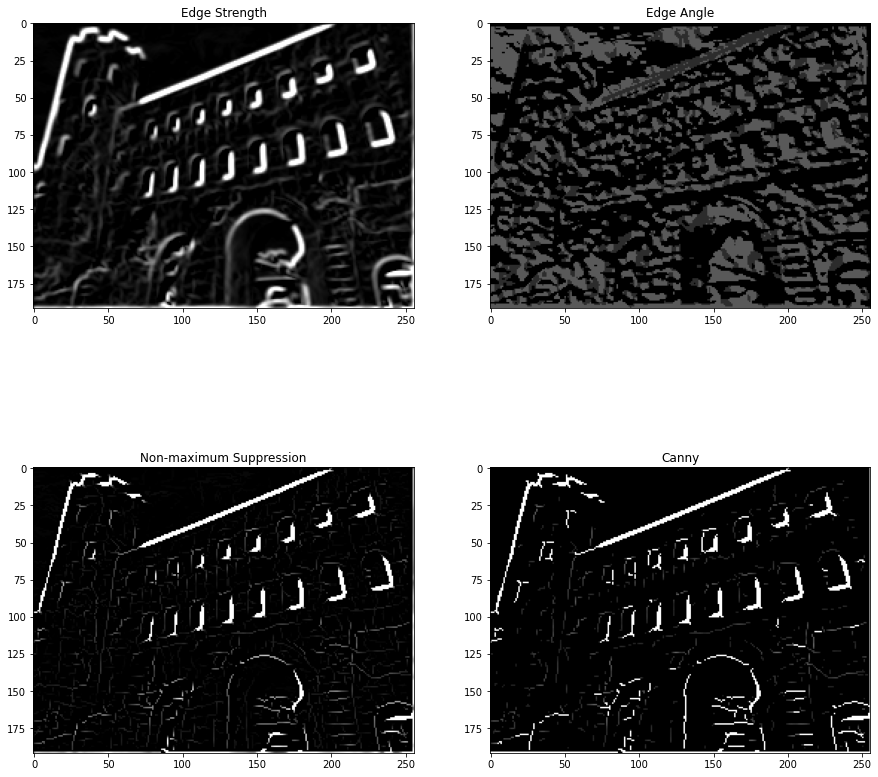

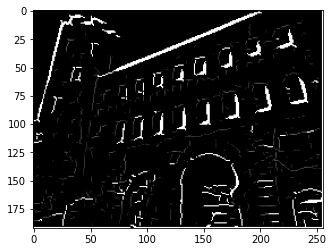

In [21]:
img = img.astype(np.float32)
canny = CannyEdgeDetector()
edge_out = canny.detect_edge(img)
plt.imshow(edge_out, cmap="gray", vmin=0, vmax=255)
plt.show()

In [43]:
class HoughTransform:
    def __call__(self, img, sample=20):
        canny = CannyEdgeDetector()
        edge = canny.detect_edge(img)
        img_out = self.inverse_hough(img, edge, sample)
        return img_out
    
    def create_histogram(self, edge):
        H, W = edge.shape
        rmax = np.ceil(np.hypot(H, W)).astype(int)
        edge_points = np.where(edge == 255)
        
        vote_counter = np.zeros((2*rmax, 180))
        for y, x in zip(edge_points[0], edge_points[1]):
            for t in range(180):
                rad = t * np.pi / 180
                rho = int(x*np.cos(rad) + y*np.sin(rad))
                vote_counter[rho + rmax, t] += 1
        return vote_counter
    
    def non_maximum_suppression(self, vote_counter_):
        H, W = vote_counter_.shape
        vote_counter = vote_counter_.copy()
        for i in range(H):
            for j in range(W):
                for dy in range(-1, 2):
                    for dx in range(-1, 2):
                        ni, nj = i + dy, j + dx
                        if ni < 0 or ni >= H or nj < 0 or nj >= W: continue
                        if vote_counter_[i, j] < vote_counter_[ni, nj]:
                            vote_counter[i, j] = 0
        return vote_counter
    
    def find_local_maxima(self, vote_counter, sample=20):
        vote_counter_nms = self.non_maximum_suppression(vote_counter)
        
        ind_x = np.argsort(vote_counter_nms.ravel())[::-1][:sample]
        ind_y = ind_x.copy()
        rhos = ind_y // 180
        thetas = ind_x % 180
        
        vote_counter_local = np.zeros_like(vote_counter_nms, dtype=np.int)
        vote_counter_local[rhos, thetas] = 255
        return rhos, thetas, vote_counter_local
    
    def inverse_hough(self, img, edge, sample=20, visualize=True):
        vote_counter = self.create_histogram(edge)
        rhos, thetas, vote_counter_local = self.find_local_maxima(vote_counter, sample)
        rmax = vote_counter.shape[0] // 2
        rhos -= rmax
        
        H, W, ch = img.shape
        img_out = img.copy()
        for r, theta in zip(rhos, thetas):
            t = np.pi / 180 * theta
            for y in range(H):
                if np.cos(t) == 0: continue
                x = int(-np.sin(t) / np.cos(t) * y + r / np.cos(t))
                if 0 <= x < W: img_out[y, x, :] = [0, 0, 255]
            for x in range(W):
                if np.sin(t) == 0: continue
                y = int(-np.cos(t) / np.sin(t) * x + r / np.sin(t))
                if 0 <= y < H: img_out[y, x, :] = [0, 0, 255]
        img_out = img_out.astype("uint8")
        
        if visualize:
            plt.figure(figsize=(20, 20))
            plt.subplot(3, 1, 1)
            plt.imshow(vote_counter, cmap="gray", vmin=0, vmax=255)
            plt.title("voting")
            plt.subplot(3, 1, 2)
            plt.imshow(vote_counter_local, cmap="gray", vmin=0, vmax=255)
            plt.title("voting (local)")
            plt.subplot(3, 1, 3)
            plt.imshow(cv2.cvtColor(img_out, cv2.COLOR_BGR2RGB))
            plt.title("output image")
            plt.show()
        return img_out

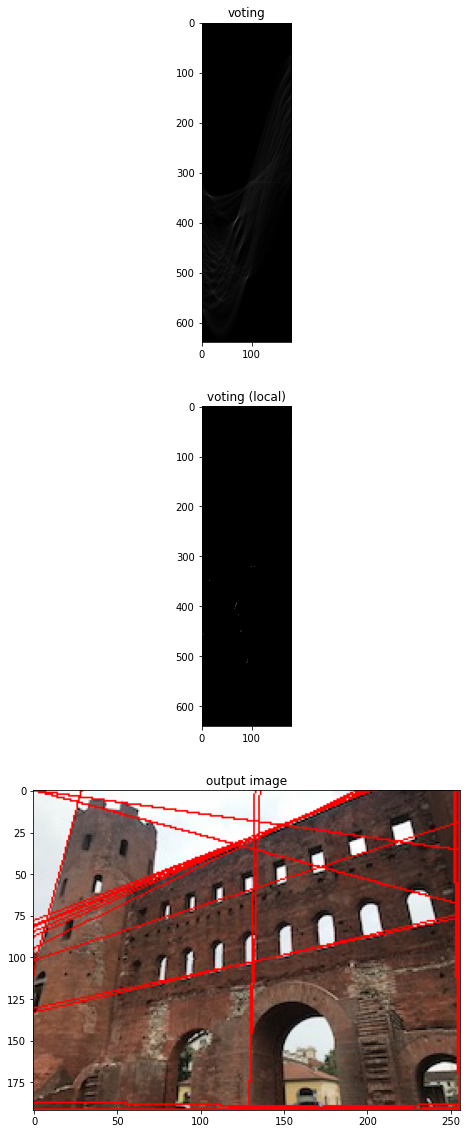

In [44]:
hough = HoughTransform()
img_out = hough.inverse_hough(img, edge_out)